1. 以下关于SVM的说法不正确的是：   
   A. SVM的目标是寻找一个使最小几何间隔达到最大值的分割超平面。   
   B. 分割超平面不会随$(w,b)$的幅值改变而改变，但是函数间隔却会随之改变。   
   C. 为训练完成的SVM中添加新的不重复的样本点，模型给出的分隔超平面可能不会改变。   
   D. 样本函数间隔的数值越大，分类结果的确信度越大。  

答：      
A. 正确。SVM的目标是找到一个最大化间隔的超平面来讲数据分类，就等价于使得几何间隔的最小值尽可能大。    
B. 正确。分割超平面的位置和方向由$w$的方向和$b$的值确定，这个两个值一定幅度缩放不会影响分割超平面，而函数间隔会随之改变。    
$$函数间隔=y_i(w^Tx_i+b),几何间隔=\frac{函数间隔}{||w||}$$  
C. 正确。分割超平面是由支持向量决定的。如果添加的新样本点不是支持向量，那么分割超平面不会改变。（可能会有轻微的影响）  
D. 错误。函数间隔数值越大说明样本离分割超平面越远，但是数值大小不意味着确信度会更高，分类结果的确信度一般与几何间隔有关，与函数间隔的数值无关，几何间隔才是再全局数据下样本点到分割超平面的实际距离，几何间隔越大，分类结果的确信度越大。

---

2. 以下关于核函数的说法不正确的是：  
   A. 核函数的数值大小反映了两个变量之间的相似度高低。  
   B. SVM只着眼于内积计算，因此训练时可以使用核函数来代替特征映射$\phi$。  
   C. SVM在训练过程中不需要进行显式的特征映射，不过在预测时需要计算样本进行特征映射。  
   D. 核函数将特征映射和内积并为了一步进行计算，所以大大降低了时间复杂度。

答：  
A. 正确。核函数是两个数据在高维特征空间的内积，衡量了数据在特征空间上的相似度，数值大小反映相似度高低。
B. 错误。SVM使用核函数代替特征映射$\phi$是因为特征映射的显式计算比较困难，消耗计算空间，使用核函数能使用内积计算降低复杂度。而SVM主要进行内积计算，不能说SVM只着眼于内积计算才选择核函数。
C. 正确。SVM使用了核函数不需要显式计算特征映射。预测的适合讲计算的内积重新映射出阿里进行分类。
D. 正确。核函数无需显式的计算特征映射，降低了样本点在高维特征空间的计算复杂度。

---

3. 在逻辑斯谛回归中，我们也用解析方式求出了模型参数，但是其中涉及复杂度很高的矩阵乘法和矩阵求逆。为什么支持向量机的解析结果中不包含这类复杂运算？（提示：逻辑斯谛回归和支持向量机分别考虑了样本到分隔平面的什么间隔？）

答：
- 逻辑斯谛回归是基于概率进行分类。逻辑斯谛回归的优化目标是最大化似然函数或最小化损失函数，没有很明确需要考虑的间隔，而是要对全部数据进行计算求解析解，或者通过梯度下降来优化损失函数。
- 支持向量机是寻找分隔超平面进行分类。支持向量机的优化目标是最大化支持向量几何间隔，通过拉格朗日乘子和对偶问题将计算转化为凸优化问题，只涉及支持向量的计算，计算的复杂度会大大降低。并且相较于逻辑斯谛回归，支持向量机不需要逆运算优化目标去求解模型参数。

---

4. 对于同一个数据集，逻辑斯谛回归和支持向量机给出的分隔平面一样吗？用本章的`linear.csv`数据集验证你的想法。试着给数据集中手动添加一些新的样本点，或者更改已有样本点的分类。两种算法给出的分隔平面有什么变化？

答：分隔平面略有不同。
- 添加新的样本点时
  - 若添加的不是支持向量，那么对两种算法都没有太大影响。
  - 若添加的是支持向量，支持向量机将变化较大，逻辑斯谛回归几乎没有变化。
- 更改样本点分类时
  - 逻辑斯谛回归没有太大变化。
  - 支持向量机将变化较大。 

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange

data = np.loadtxt('../linear.csv', delimiter=',')
print('数据集大小：', len(data))
x = data[:, :2]
y = data[:, 2]

数据集大小： 200


In [25]:
# SVM的SMO算法实现
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-q/2p更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) + b - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) + b - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新b
            b_i = b - e_i - y[i] * (alpha_i - alpha[i]) * K[i, i] - y[j] * (alpha_j - alpha[j]) * K[i, j]
            b_j = b - e_j - y[j] * (alpha_j - alpha[j]) * K[j, j] - y[i] * (alpha_i - alpha[i]) * K[i, j]
            if 0 < alpha_i < C:
                b = b_i
            elif 0 < alpha_j < C:
                b = b_j
            else:
                b = (b_i + b_j) / 2
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha, b

In [26]:
# 设置超参数
C = 1e8 # 由于数据集完全线性可分，我们不引入松弛变量
max_iter = 1000
np.random.seed(0)

alpha, b = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

  1%|▏         | 13/1000 [00:00<00:07, 129.66it/s]

100%|██████████| 1000/1000 [00:10<00:00, 96.58it/s]


In [27]:
# 逻辑斯谛回归训练同样的数据集

# 划分训练集与测试集
np.random.seed(0)
ratio = 0.7
split = int(len(x) * ratio)
idx = np.random.permutation(len(x))
x_total = x[idx]
y_total = y[idx]
x_train, y_train = x_total[:split], y_total[:split]
x_test, y_test = x_total[split:], y_total[split:]

from sklearn.linear_model import LogisticRegression

# 使用线性模型中的逻辑回归模型在数据集上训练
# 其提供的liblinear优化算法适合在较小数据集上使用
# 默认使用系数为1.0的L2正则化约束
# 其他可选参数请参考官方文档
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(x_train, y_train)
print('回归系数：', lr_clf.coef_[0], lr_clf.intercept_)

# 在数据集上用计算得到的逻辑回归模型进行预测并计算准确度
y_pred = lr_clf.predict(x_test)
print('准确率为：',np.mean(y_pred == y_test))

回归系数： [-1.95277304  2.93186174] [-1.93002323]
准确率为： 1.0


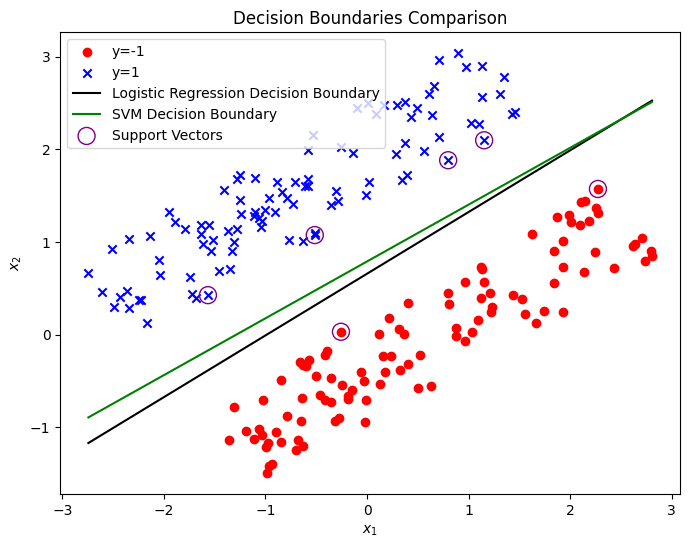

In [28]:
plt.figure(figsize=(8, 6))

# 绘制数据点
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')

# 绘制逻辑斯蒂回归的分隔平面
X = np.linspace(np.min(x_total[:, 0]), np.max(x_total[:, 0]), 100)
slope = -lr_clf.coef_[0, 0] / lr_clf.coef_[0, 1]
intercept = -lr_clf.intercept_ / lr_clf.coef_[0, 1]
Y_lr = slope * X + intercept
plt.plot(X, Y_lr, color='black', label='Logistic Regression Decision Boundary')

# 绘制支持向量机的分隔平面
sup_idx = alpha > 1e-5
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
b = y[sup_idx][0] - np.dot(w, x[sup_idx][0])
Y_svm = -(w[0] * X + b) / (w[1] + 1e-5)
plt.plot(X, Y_svm, color='green', label='SVM Decision Boundary')

# 标记支持向量
plt.scatter(x[sup_idx, 0], x[sup_idx, 1], marker='o', color='none', 
            edgecolor='purple', s=150, label='Support Vectors')

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Decision Boundaries Comparison')
plt.legend()
plt.show()


逻辑斯蒂回归模型的参数：
回归系数： [-2.18568975  3.20497694] [-2.1932403]


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 94.48it/s] 



支持向量机模型的参数：
支持向量个数： 7
参数： [-1.95008048  3.46107447] -3.8071302279474537


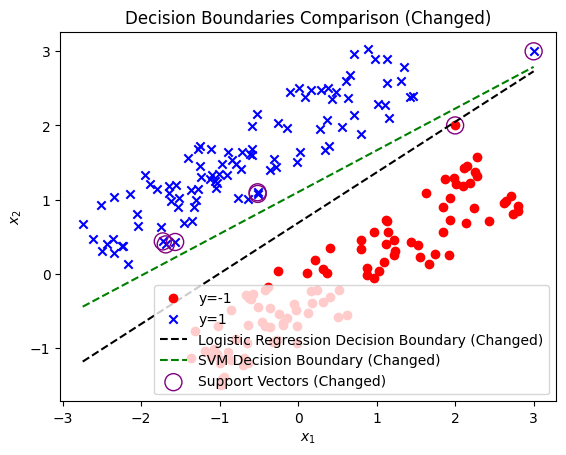

In [36]:
# # 随机选择一些样本点并更改它们的类别
# np.random.seed(0)
# change_indices = np.random.choice(len(y), size=1, replace=False)
# x_changed = x.copy()
# y_changed = y.copy()
# y_changed[change_indices] *= -1  # 更改选定样本点的类别

# 增加一些样本点
x_extra = np.array([[2, 2], [3, 3]])  # 新增两个样本点
y_extra = np.array([-1, 1])  # 给新样本点指定类别

x_changed = np.concatenate((x, x_extra), axis=0)
y_changed = np.concatenate((y, y_extra))



# 重新训练逻辑斯蒂回归模型
lr_clf_changed = LogisticRegression(solver='liblinear')
lr_clf_changed.fit(x_changed, y_changed)
# 打印逻辑斯蒂回归模型的参数
print("逻辑斯蒂回归模型的参数：")
print("回归系数：", lr_clf_changed.coef_[0], lr_clf_changed.intercept_)

# 重新训练支持向量机模型
alpha_changed, b_changed = SMO(x_changed, y_changed, ker=np.inner, C=C, max_iter=max_iter)
# 打印支持向量机模型的参数
sup_idx_changed = alpha_changed > 1e-5
print("\n支持向量机模型的参数：")
print("支持向量个数：", np.sum(alpha_changed > 1e-5))
w_changed = np.sum((alpha_changed[sup_idx_changed] * y_changed[sup_idx_changed]).reshape(-1, 1) * x_changed[sup_idx_changed], axis=0)
b_changed = y_changed[sup_idx_changed][0] - np.dot(w_changed, x_changed[sup_idx_changed][0])
print("参数：", w_changed, b_changed)


# 绘制分隔平面
plt.figure()

# 绘制数据点
plt.scatter(x_changed[y_changed == -1, 0], x_changed[y_changed == -1, 1], color='red', label='y=-1')
plt.scatter(x_changed[y_changed == 1, 0], x_changed[y_changed == 1, 1], marker='x', color='blue', label='y=1')

# 绘制逻辑斯蒂回归的分隔平面
X = np.linspace(np.min(x_changed[:, 0]), np.max(x_changed[:, 0]), 100)
slope = -lr_clf_changed.coef_[0, 0] / lr_clf_changed.coef_[0, 1]
intercept = -lr_clf_changed.intercept_ / lr_clf_changed.coef_[0, 1]
Y_lr = slope * X + intercept
plt.plot(X, Y_lr, color='black', linestyle='--', label='Logistic Regression Decision Boundary (Changed)')

# 绘制支持向量机的分隔平面
w_changed = np.sum((alpha_changed[sup_idx_changed] * y_changed[sup_idx_changed]).reshape(-1, 1) * x_changed[sup_idx_changed], axis=0)
b_changed = y_changed[sup_idx_changed][0] - np.dot(w_changed, x_changed[sup_idx_changed][0])
Y_svm_changed = -(w_changed[0] * X + b_changed) / (w_changed[1] + 1e-5)
plt.plot(X, Y_svm_changed, color='green', linestyle='--', label='SVM Decision Boundary (Changed)')

# 标记支持向量
plt.scatter(x_changed[sup_idx_changed, 0], x_changed[sup_idx_changed, 1], marker='o', color='none', 
            edgecolor='purple', s=150, label='Support Vectors (Changed)')

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Decision Boundaries Comparison (Changed)')
plt.legend()
plt.show()

---

5. 思考RBF核函数对应的$\phi(\cdot)$函数是什么，建议查阅相关文献来寻找答案。进一步思考输出为无穷维的特征映射$\phi(\cdot)$的意义是什么。

答：暂时没找到答案。

---

6. 试基于本章代码，标记出双螺旋数据上使用RBF核函数的SVM模型的支持向量，并讨论这些数据点成为支持向量的原因。

答：在这种螺旋的复杂数据中，这些数据点都是在类别的边界附件，是划分边界的支持向量。

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import trange

data = np.loadtxt('../spiral.csv', delimiter=',')
print('数据集大小：', len(data))
x = data[:, :2]
y = data[:, 2]

数据集大小： 194


In [ ]:
# SVM的SMO算法实现
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-q/2p更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) + b - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) + b - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新b
            b_i = b - e_i - y[i] * (alpha_i - alpha[i]) * K[i, i] - y[j] * (alpha_j - alpha[j]) * K[i, j]
            b_j = b - e_j - y[j] * (alpha_j - alpha[j]) * K[j, j] - y[i] * (alpha_i - alpha[i]) * K[i, j]
            if 0 < alpha_i < C:
                b = b_i
            elif 0 < alpha_j < C:
                b = b_j
            else:
                b = (b_i + b_j) / 2
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha, b

In [41]:
# 简单多项式核
def simple_poly_kernel(d):
    def k(x, y): 
        return np.inner(x, y) ** d
    return k

# RBF核
def rbf_kernel(sigma):
    def k(x, y):
        return np.exp(-np.inner(x - y, x - y) / (2.0 * sigma ** 2))
    return k

# 余弦相似度核
def cos_kernel(x, y):
    return np.inner(x, y) / np.linalg.norm(x, 2) / np.linalg.norm(y, 2)

# sigmoid核
def sigmoid_kernel(beta, c):
    def k(x, y):
        return np.tanh(beta * np.inner(x, y) + c)
    return k

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:05<00:00, 99.83it/s] 


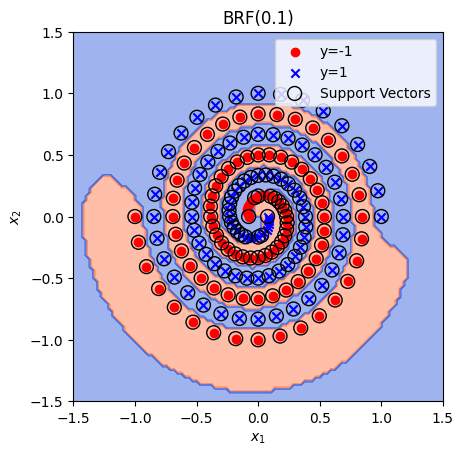

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import trange

def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
    b = 0
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-q/2p更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) + b - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) + b - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新b
            b_i = b - e_i - y[i] * (alpha_i - alpha[i]) * K[i, i] - y[j] * (alpha_j - alpha[j]) * K[i, j]
            b_j = b - e_j - y[j] * (alpha_j - alpha[j]) * K[j, j] - y[i] * (alpha_i - alpha[i]) * K[i, j]
            if 0 < alpha_i < C:
                b = b_i
            elif 0 < alpha_j < C:
                b = b_j
            else:
                b = (b_i + b_j) / 2
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha, b

data = np.loadtxt('../spiral.csv', delimiter=',')
x = data[:, :2]
y = data[:, 2]

# RBF核
def rbf_kernel(sigma):
    def k(x, y):
        return np.exp(-np.inner(x - y, x - y) / (2.0 * sigma ** 2))
    return k

# 绘图准备
np.random.seed(0)
plt.figure()
cmap = ListedColormap(['coral', 'royalblue'])

# 开始求解 SVM
alpha, b = SMO(x, y, rbf_kernel(0.1), C=100, max_iter=500)
sup_idx = alpha > 1e-6 # 支持向量的系数不为零
sup_x = x[sup_idx] # 支持向量
sup_y = y[sup_idx]

# 构造网格并用 SVM 预测分类
G = np.linspace(-1.5, 1.5, 100)
G = np.meshgrid(G, G)
X = np.array([G[0].flatten(), G[1].flatten()]).T # 转换为每行一个向量的形式

# 用支持向量计算 w^T*x
def wx(x_new):
    s = 0
    for xi, yi, ai in zip(sup_x, sup_y, alpha):
        s += yi * ai * rbf_kernel(0.1)(xi, x_new)
    return s

# 构造网格并用 SVM 预测分类
Y = np.array([wx(xi) + b for xi in X])
Y[Y < 0] = -1
Y[Y >= 0] = 1
Y = Y.reshape(G[0].shape)

# 数据集可视化
plt.contourf(G[0], G[1], Y, cmap=cmap, alpha=0.5)


# 数据集可视化
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')

# 标记支持向量
plt.scatter(sup_x[:, 0], sup_x[:, 1], s=100, edgecolors='k', facecolors='none', label='Support Vectors')

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.title('BRF(0.1)')
plt.axis('square')
plt.show()

核函数： Poly(3)


100%|██████████| 500/500 [00:05<00:00, 84.95it/s]


核函数： RBF(0.1)


100%|██████████| 500/500 [00:06<00:00, 71.94it/s]


核函数： Cos


100%|██████████| 500/500 [00:05<00:00, 87.28it/s] 


核函数： Sigmoid(1,-1)


100%|██████████| 500/500 [00:05<00:00, 91.37it/s] 


<Figure size 640x480 with 0 Axes>

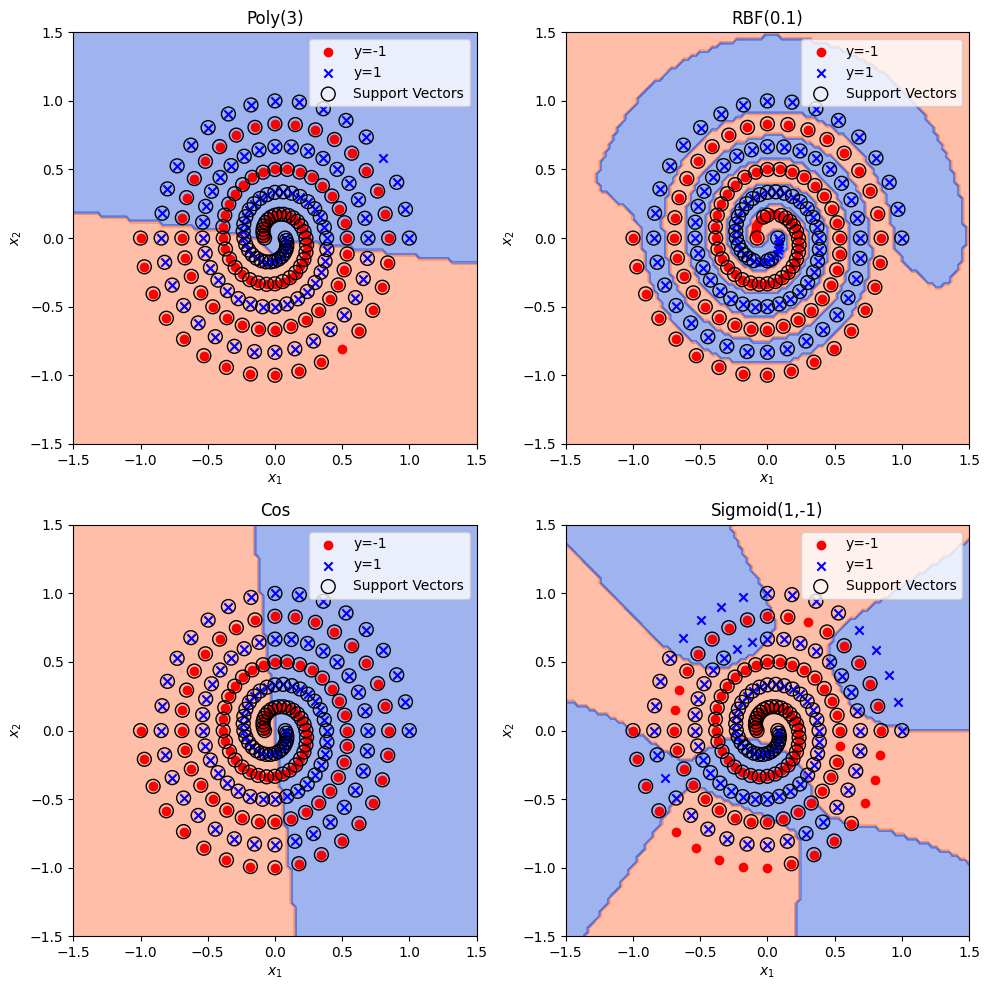

In [47]:
# 绘图准备，构造网格
np.random.seed(0)
plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
cmap = ListedColormap(['coral', 'royalblue'])

# 开始求解 SVM
for i in range(len(kernels)):
    print('核函数：', ker_names[i])
    alpha, b = SMO(x, y, kernels[i], C=C, max_iter=max_iter)
    sup_idx = alpha > 1e-6 # 支持向量的系数不为零
    sup_x = x[sup_idx] # 支持向量
    sup_y = y[sup_idx]
    sup_alpha = alpha[sup_idx]

    # 用支持向量计算 w^T*x
    def wx(x_new):
        s = 0
        for xi, yi, ai in zip(sup_x, sup_y, sup_alpha):
            s += yi * ai * kernels[i](xi, x_new)
        return s

    # 构造网格并用 SVM 预测分类
    G = np.linspace(-1.5, 1.5, 100)
    G = np.meshgrid(G, G)
    X = np.array([G[0].flatten(), G[1].flatten()]).T # 转换为每行一个向量的形式
    Y = np.array([wx(xi) + b for xi in X])
    Y[Y < 0] = -1
    Y[Y >= 0] = 1
    Y = Y.reshape(G[0].shape)
    axs[i].contourf(G[0], G[1], Y, cmap=cmap, alpha=0.5)
    
    # 绘制原数据集的点
    axs[i].scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
    axs[i].scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')

    # 标记支持向量
    axs[i].scatter(sup_x[:, 0], sup_x[:, 1], s=100, edgecolors='k', facecolors='none', label='Support Vectors')

    axs[i].set_title(ker_names[i])
    axs[i].set_xlabel(r'$x_1$')
    axs[i].set_ylabel(r'$x_2$')
    axs[i].legend()

plt.tight_layout()
plt.savefig('output_24_2.png')
plt.savefig('output_24_2.pdf')
plt.show()


---

7. 试通过参数量与数据集大小的关系、参数更新方式等视角，分析和体会SVM模型的原问题对应参数化模型，而对偶问题对应非参数化模型。

答：  
SVM模型的原问题是一个带约束的凸优化问题，对偶问题是通过拉格朗日乘子法对偶转换的。
- 参数量与数据集大小
  - 原问题是需要计算每一个数据去优化权重和偏置，就是求解参数化的权重和偏置来找到分隔平面
  - 对偶问题是计算拉格朗日乘子的值，和优化这个乘子，而不是直接去优化分隔平面的参数
- 参数更新
  - 原问题是优化损失函数，需要梯度下降，对参数是进行连续优化更新的
  - 对偶问题是优化拉格朗日乘子，优化完乘子再根据乘子计算权重和偏置，对参数是离散优化更新的
- 对参数决定
  - 原问题是直接决定参数的
  - 对偶问题是决定拉格朗日乘子间接决定参数的